In [2]:
import os
import cv2
import pickle
import matlab.engine
import scipy.io
import scipy.misc
import numpy as np
import scipy as sp
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.feature_extraction.image import extract_patches_2d


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
IMAGES_PATH = "C:\Projects\BlurProject\BlurClassification\images\\"
FEATURES_PATH = "C:\Projects\BlurProject\BlurClassification\extracted\\"
GT_PATH = "C:\Projects\BlurProject\BlurClassification\gt\\"
GT_SOLID_PATH = "C:\Projects\BlurProject\BlurClassification\gt_solid\\"
FEATURE_LIST = ['GHS','LK','LLF1','LLF2','LPSS','LST']
PATCH_SIZE = 21
targets_with_solid = list(map(lambda x: x.split(".")[0] ,os.listdir(GT_SOLID_PATH)))

In [6]:
targets_without_solid = [
    "motion0001",
    "motion0002",
    "motion0004",
    "motion0028",
    "motion0035",
    "motion0036",
    "motion0082",
    "motion0102",
    "motion0104",
    "motion0134",
    "motion0136",
    "motion0209",
    "motion0222",
    "motion0254",
    "out_of_focus0021",
    "out_of_focus0014",
    "out_of_focus0031",
    "out_of_focus0066",
    "out_of_focus0109",
    "out_of_focus0137",
    "out_of_focus0179",
    "out_of_focus0191",
    "out_of_focus0269",
    "out_of_focus0318",
    "out_of_focus0522"    
]

In [7]:
targets = targets_without_solid+targets_with_solid

In [8]:
def get_first_channel(image):
    if(len(image.shape) > 2):
        return image[:,:,0]
    return image

def get_gt(target):
    gt_blur = get_first_channel(scipy.misc.imread(GT_PATH+target+".png")/255)    
    if(os.path.isfile(GT_SOLID_PATH+target+".png")):
        gt_solid = get_first_channel(scipy.misc.imread(GT_SOLID_PATH+target+".png")/255)
        gt = np.array(list(map(lambda x,y: list(map(lambda x,y: 2 if y < 1 else x, x,y)), gt_blur,gt_solid)))
    else:
        gt = gt_blur
    return gt.astype(int)

In [9]:
FIRST_KERNEL_SIZE = 11
SECOND_KERNEL_SIZE = 5
N_COLOURS = 10
THRESHOLD = 0.0001

def get_kernel(size):
    return np.ones((size,size),np.float32)/(size**2)

def reduce_color_count(image,n_colours):
    im_heigth = image.shape[0]
    im_width = image.shape[1]
    KM = KMeans(n_clusters=n_colours,init='k-means++')
    image2 = KM.fit_predict(image.reshape((im_heigth*im_width,image.shape[2])))
    image2 = np.array(list(map(lambda x: KM.cluster_centers_[x],image2)))
    image2 = image2.reshape((im_heigth,im_width,3))
    return 255 - image2.astype(int)

def get_unicolor_mask(target):
    image = scipy.misc.imread(IMAGES_PATH+target+".jpg")
    first_kernel = get_kernel(FIRST_KERNEL_SIZE)
    second_kernel = get_kernel(SECOND_KERNEL_SIZE)
    clustered_image = reduce_color_count(image,N_COLOURS)    
    blurred_clustered_image = cv2.filter2D(clustered_image,-1,first_kernel)
    clustered_images_difference = (np.sum((np.abs(clustered_image - blurred_clustered_image))/3.0,axis=2)).astype(float)
    #smoothing
    solid_color_areas  = cv2.filter2D(clustered_images_difference,-1,second_kernel)
    #normalisation
    solid_color_areas = (solid_color_areas - np.min(solid_color_areas))/np.max(solid_color_areas)
    #edges restoration
    solid_color_areas = 1-np.arctan(solid_color_areas/THRESHOLD)
    return solid_color_areas > 0.5

In [10]:
def get_data(target):
    data = {}
    for feature in FEATURE_LIST:
        data[feature] = pd.read_csv(FEATURES_PATH+target+"\\"+str(PATCH_SIZE)+"\\"+feature+".csv").values
    unicolor = get_unicolor_mask(target)
    offset = int((unicolor.shape[0]-data[feature].shape[0])/2)
    data["UNICOLOR"] = unicolor[offset:-offset-1,offset:-offset]
    gt = get_gt(target)
    offset = int((gt.shape[0]-data[feature].shape[0])/2)
    data["GT"] = gt[offset:-offset-1,offset:-offset]
    shape = data["GT"].shape
    dataframe = pd.DataFrame()
    for key in data.keys():
        dataframe[key] = data[key].reshape(shape[0]*shape[1])
    dataframe.UNICOLOR=dataframe.UNICOLOR.astype(int)
    return (dataframe,shape)

In [ ]:
data = []
for i,target in enumerate(targets):
    print('%s , %d from %d' % (target,i,len(targets)))
    data.append(get_data(target)[0])
result = pd.concat(data)
pickle.dump(result,open('data.bin','wb'))
print("Done")

In [ ]:
y = result.GT
X = result.drop('GT',axis=1)

In [ ]:
xg_params = {}
xg_params[11] = {'colsample_bytree': 0.7,
  'gamma': 0.0,
  'max_depth': 19,
  'min_child_weight': 0,
  'n_estimators': 170,
  'reg_alpha': 0,
  'subsample': 0.95}
xg_params[15] = {'colsample_bytree': 0.5,
  'gamma': 0.0,
  'max_depth': 19,
  'min_child_weight': 0,
  'n_estimators': 190,
  'reg_alpha': 0,
  'subsample': 0.9}
xg_params[21] = {'colsample_bytree': 0.85,
  'gamma': 0.0,
  'max_depth': 20,
  'min_child_weight': 0,
  'n_estimators': 190,
  'reg_alpha': 1e-05,
  'subsample': 0.95}

In [ ]:
classifier = xgb.XGBClassifier(max_depth=xg_params[PATCH_SIZE]['max_depth'],
                               n_estimators=xg_params[PATCH_SIZE]['n_estimators'],
                               min_child_weight=xg_params[PATCH_SIZE]['min_child_weight'],
                               reg_alpha=xg_params[PATCH_SIZE]['reg_alpha'],
                               subsample=xg_params[PATCH_SIZE]['subsample'],
                               objective='multi:softmax',
                               nthread=4)
%time classifier.fit(X,y)
classifier.booster().save_model('./classifier'+str(PATCH_SIZE)+'.bin')

# TEST

In [108]:
test_target = targets_with_solid[2]

In [109]:
classifier = xgb.XGBClassifier()
booster = xgb.Booster()
booster.load_model('./classifier21.bin')
classifier._Booster = booster

In [110]:
data,shape = get_data(test_target)

In [111]:
data.head(2)

LPSS  GT      LK  UNICOLOR       GHS       LST     LLF1      LLF2
0 -118.50   0  1.3770         0  0.079486  0.011509 -0.95962 -0.185360
1 -118.39   0  1.3591         0  0.079486  0.011225 -1.29180  0.008308

In [112]:
pred = classifier.predict_proba(data.drop('GT',axis=1))

In [113]:
clear_map = pred[0,int(pred.shape[1]/2):].reshape(shape)
blur_map = pred[1,int(pred.shape[1]/2):].reshape(shape)
solid_map = pred[2,:int(pred.shape[1]/2)].reshape(shape)

(([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

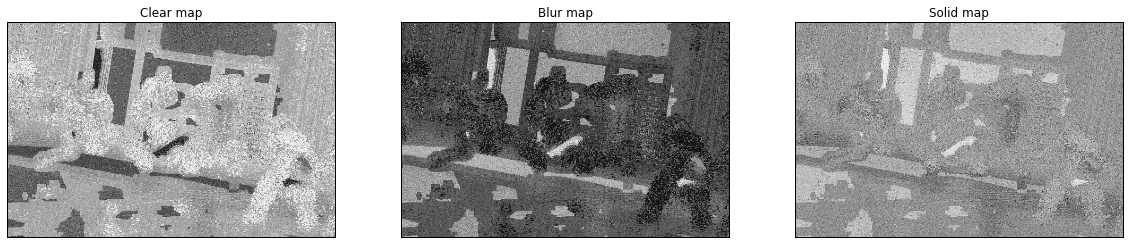

In [114]:
plt.figure(0,figsize=(20,12))
plt.subplot(1,3,1),plt.imshow(clear_map,cmap='gray'),plt.title('Clear map')
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,2),plt.imshow(blur_map,cmap='gray'),plt.title('Blur map')
plt.xticks([]), plt.yticks([])
plt.subplot(1,3,3),plt.imshow(solid_map,cmap='gray'),plt.title('Solid map')
plt.xticks([]), plt.yticks([])

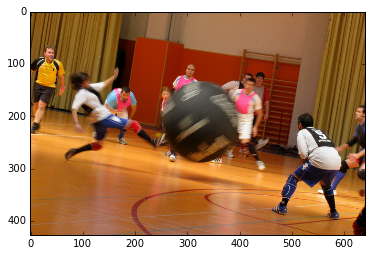

In [115]:
plt.imshow(sp.misc.imread(IMAGES_PATH+test_target+'.jpg'))

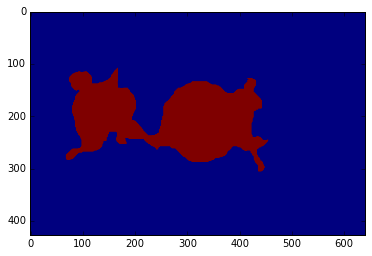

In [116]:
plt.imshow(sp.misc.imread(GT_PATH+test_target+'.png'))

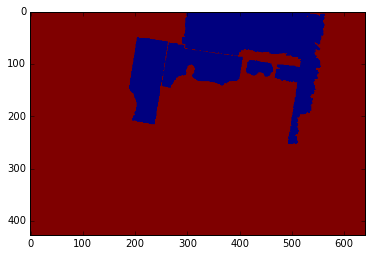

In [117]:
plt.imshow(sp.misc.imread(GT_SOLID_PATH+test_target+'.png'))